In [1]:
import uuid, sys, os
import requests
import random
import pandas as pd
import math
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats

from transformers import EsmModel, AutoTokenizer # huggingface
import esm

import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
torch.manual_seed(0)
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW
from accelerate import Accelerator
import training_utils.partitioning_utils as pat_utils
from torch.utils.checkpoint import checkpoint

# LoRA
from peft import LoraConfig, get_peft_model

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
print("PyTorch:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.9.1+cu128
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [3]:
# requests.get("https://api.wandb.ai/status").status_code

# import wandb
# wandb.login(key="f8a6d759fe657b095d56bddbdb4d586dfaebd468", relogin=True)

In [4]:
### Setting a seed to have the same initiation of weights

def set_seed(seed: int = 0):
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # CuDNN settings (for convolution etc.)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # (Optional) for some Python hashing randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 0
set_seed(SEED)

In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing

seq_embed_dimension = 1280 #| 960 | 1152
# struct_embed_dimension = 256
number_of_recycles = 2
padding_value = -5000

In [6]:
# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


In [7]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

## Loading data

In [8]:
meta_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_w_pbd_lens.csv").drop(columns = ["binder_id", "target_id"]).rename(columns = {
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})

meta_df["target_id_mod"] = [str("t_"+row.target_id) for __, row in meta_df.iterrows()]

# Interaction Dict
meta_df_shuffled = meta_df.sample(frac=1, random_state=0).reset_index(drop=True)
meta_df_shuffled

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id,binder_id,seq_len_binder,seq_len_target,pdb_len_binder,pdb_len_target,target_id_mod
0,A,"[""B""]",True,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_124,62,101,62,101,t_FGFR2
1,A,"[""B""]",False,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_149,58,621,58,621,t_EGFR_2
2,A,"[""B""]",False,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_339,65,101,65,101,t_FGFR2
3,A,"[""B""]",False,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1234,64,101,64,101,t_FGFR2
4,A,"[""B""]",False,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_48,65,165,65,165,t_IL2Ra
...,...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,SEDELRELVKEIRKVAEKQGDKELRTLWIEAYDLLASLWYGAADEL...,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,SARS_CoV2_RBD,SARS_CoV2_RBD_25,63,195,63,195,t_SARS_CoV2_RBD
3528,A,"[""B""]",False,TEEEILKMLVELTAHMAGVPDVKVEIHNGTLRVTVNGDTREARSVL...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2027,65,101,65,101,t_FGFR2
3529,A,"[""B""]",False,VEELKEARKLVEEVLRKKGDQIAEIWKDILEELEQRYQEGKLDPEE...,DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKC...,IL7Ra,IL7Ra_90,63,193,63,193,t_IL7Ra
3530,A,"[""B""]",False,DAEEEIREIVEKLNDPLLREILRLLELAKEKGDPRLEAELYLAFEK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1605,65,101,65,101,t_FGFR2


In [9]:
meta_df_shuffled_LONG_binder = meta_df_shuffled[["binder_id", "binder_seq", "seq_len_binder"]].rename(columns = {
    "binder_id" : "ID",
    "binder_seq" : "sequence",
    "seq_len_binder": "seq_len",
})

meta_df_shuffled_LONG_taget = meta_df_shuffled[["target_id_mod", "target_seq", "seq_len_target"]].rename(columns = {
    "target_id_mod" : "ID",
    "target_seq" : "sequence",
    "seq_len_target": "seq_len",
}).drop_duplicates(subset="ID", keep="first")

meta_df_shuffled_LONG = pd.concat([meta_df_shuffled_LONG_binder, meta_df_shuffled_LONG_taget], axis=0, ignore_index=True)
meta_df_shuffled_LONG

,ID,sequence,seq_len
0,FGFR2_124,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,62
1,EGFR_2_149,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,58
2,FGFR2_339,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,65
3,FGFR2_1234,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,64
4,IL2Ra_48,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,65
...,...,...,...
3543,t_SARS_CoV2_RBD,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,195
3544,t_VirB8,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,138
3545,t_sntx_2,MICHNQQSSQPPTTKTCSEGQCYKKTWRDHRGTIIERGCGCPTVKP...,60
3546,t_sntx,MICYNQQSSQPPTTKTCSETSCYKKTWRDHRGTIIERGCGCPKVKP...,60


In [10]:
unique_ids = meta_df_shuffled_LONG["ID"].unique()

train_ids = pd.Series(unique_ids).sample(
    frac=0.8, random_state=0
)

test_ids = pd.Series(unique_ids)[
    ~pd.Series(unique_ids).isin(train_ids)
]

meta_df_shuffled_LONG_train = meta_df_shuffled_LONG[
    meta_df_shuffled_LONG.ID.isin(train_ids)
].reset_index(drop=True)

meta_df_shuffled_LONG_test = meta_df_shuffled_LONG[
    meta_df_shuffled_LONG.ID.isin(test_ids)
].reset_index(drop=True)

In [11]:
meta_df_shuffled_LONG_taget.ID.unique()

array(['t_FGFR2', 't_EGFR_2', 't_IL2Ra', 't_IL7Ra', 't_Pdl1',
       't_InsulinR', 't_EGFR', 't_Mdm2', 't_TrkA', 't_LTK', 't_IL10Ra',
       't_SARS_CoV2_RBD', 't_VirB8', 't_sntx_2', 't_sntx', 't_EGFR_3'],
      dtype=object)

### Loading raw sequences and ESM-IFs

In [12]:
class CLIP_Meta_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.max_len = self.dframe["seq_len"].max()

        # index & storage
        
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            
            if accession.startswith("t_"):
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"
                
                emb_struct = np.load(os.path.join(esmIF_path, f"{accession[2:]}.npy"))
                sequence = str(self.dframe.loc[accession].sequence)

            else:
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"

                emb_struct = np.load(os.path.join(esmIF_path, f"{accession}.npy"))     # [Lb, D]
                sequence = str(self.dframe.loc[accession].sequence)            

            if len(sequence) != emb_struct.shape[0]:
                print(str(sequence), len(sequence), emb_struct.shape[0])

            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            if emb_struct.shape[0] < self.max_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.max_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.max_len] # no padding was used

            self.samples.append((sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sequence, emb_struct = self.samples[idx]
        emb_struct = torch.from_numpy(emb_struct).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe        
        return sequence, emb_struct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        sequence_list, emb_struct_list, lbl_list = zip(*out)
    
        # Stack embeddings    
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        lbl_stacked = torch.stack(lbl_list)  # [B]
    
        return list(sequence_list), emb_struct_stacked, lbl_stacked

esm2_path_binders = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
esm2_path_targets = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

## Contact maps paths
esmIF_path_binders = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
esmIF_path_targets = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"

meta_Dataset_train = CLIP_Meta_w_esmIF(
    meta_df_shuffled_LONG_train,
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

meta_Dataset_test = CLIP_Meta_w_esmIF(
    meta_df_shuffled_LONG_test,
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████| 710/710 [00:01<00:00, 534.19it/s]


In [13]:
for i in meta_Dataset_test:
    print(len(i[0]))
    print(i[1].shape)
    embed = i[1]
    break

62
torch.Size([301, 512])


#### Some testing

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=16,
            lora_alpha=128,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

$\cos(\theta) = \frac{a \cdot b}{\|a\| \, \|b\|}$

`numpy.linalg.norm` computes the vector norm, usually the Euclidean norm also called the $L2$ norm.

For vector $x = (x_1, x_2, ..., x_n)$: 

${\|x\|} = \sqrt{{x_1}^2 + {x_2}^2 + ... + {x_n}^2}$

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# _loader = DataLoader(test_Dataset, batch_size=5)
# proj = nn.Linear(1280, 512).to(device)
# encoder_ = ESM2EncoderLoRA().eval().to(device)
# # encoder_

In [ ]:
cosine_similarities = []

for batch in tqdm(_loader, total=len(_loader)):
    seqs, structs_emeb, lbls = batch
    seqs_emeb = encoder_(seqs)
    seqs_emeb_proj = proj(seqs_emeb.to(device))          # shape: [B, L, 512]

    # Create masks (must match projected embeddings)
    seq_mask = create_key_padding_mask(seqs_emeb_proj)
    struct_mask = create_key_padding_mask(structs_emeb)

    # Mean-pool (returns shape: [B, 512])
    vectors_seq = create_mean_of_non_masked(seqs_emeb_proj, seq_mask).cpu().detach().numpy()
    vectors_struct = create_mean_of_non_masked(structs_emeb, struct_mask).cpu().detach().numpy()

    # Loop through batch items
    for i in range(vectors_seq.shape[0]):
        cosine = np.dot(vectors_seq[i], vectors_struct[i]) / (norm(vectors_seq[i]) * norm(vectors_struct[i]))
        cosine_similarities.append(cosine)

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

## Contrastive Sequence-Structure Pre-training (CSSP)

In [14]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

#### ESM2 encoder

In [ ]:
# class ESM2EncoderOriginal(nn.Module):
#     def __init__(self, padding_value=-5000.0):
#         super().__init__()

#         self.padding_value = padding_value

#         self.model = EsmModel.from_pretrained(
#             "facebook/esm2_t33_650M_UR50D",
#             output_hidden_states=True
#         )
#         self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

#     @torch.no_grad()
#     def get_attentions(self, sequences):
#         inputs = self.tokenizer(
#             sequences, return_tensors="pt", padding=True
#         ).to(self.model.device)

#         out = self.model(**inputs, output_attentions=True)
#         return out.attentions   # list[num_layers] → [B, num_heads, L, L]

#     def forward(self, sequences):
#         inputs = self.tokenizer(
#             sequences, return_tensors="pt", padding=True
#         ).to(self.model.device)

#         out = self.model(**inputs)
#         reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
#         reps = reps[:, 1:-1, :]                       # remove CLS/EOS

#         seq_lengths = [len(s) for s in sequences]
#         Lmax = max(seq_lengths)

#         B, D = reps.size(0), reps.size(-1)
#         padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

#         for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
#             padded[i, :real_len] = r[:real_len]

#         return padded

In [ ]:
# sequences = []
# for i, row in Df_test_LONG.iterrows():
#     seq_name = f"prot_{i}"
#     sequence = str(row.sequence)
#     entry = (seq_name, sequence)
#     sequences.append(entry)
# sequences[:5]

# # Embedings original seqeunces
# encoder = ESM2EncoderOriginal().to("cuda")   # create model
# embeds = encoder(seq)

# print(embeds.shape)

# # Mean pooling
# seq_mask_emb = create_key_padding_mask(embeddings = embeds, padding_value = -5000.0).to(device)
# seq_embed_pooled_START = create_mean_of_non_masked(embeds, seq_mask_emb)
# seq_embed_pooled_START

### ESM encoder with LoRA added

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [ ]:
# encoder = ESM2EncoderLoRA()
# encoder = encoder.eval()
# sequences = ["MKTAGALA","GAY"]
# padded, mask = encoder(sequences)
# print(padded.shape)
# seq_mask_emb = create_key_padding_mask(embeddings = padded, padding_value = -5000.0).to(device)
# seq_embed_pooled_START = create_mean_of_non_masked(padded, seq_mask_emb)
# print(seq_embed_pooled_START)
# print(padded)

In [ ]:
# # Embedings original seqeunces
# sequences = [
#     ("seq1", "MKTAGALA"),
#     ("seq2", "GAY")
# ]
# encoder = ESM2EncoderOriginal()   # create model
# encoder = encoder.eval()
# embeds = encoder(sequences)

# # Mean pooling
# seq_mask_emb = create_key_padding_mask(embeddings = embeds, padding_value = -5000.0)
# seq_embed_pooled_START = create_mean_of_non_masked(embeds, seq_mask_emb)
# seq_embed_pooled_START
# print(embeds)

### CSSPBoostingESM model - 1

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [ ]:
class CSSPBoostingESM(nn.Module):
    def __init__(
        self,
        seq_embed_dim=1280,
        struct_embed_dim=512,
        padding_value=-5000,
        num_heads=8,
        num_recycles=2
    ):
        super().__init__()

        self.seq_embed_dim = seq_embed_dim
        self.struct_embed_dim = struct_embed_dim
        self.padding_value = padding_value
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

        # ESM2 encoder
        self.seq_encoder = ESM2EncoderLoRA()
        self.seq_down = nn.Linear(self.seq_embed_dim, self.struct_embed_dim)

    def forward(self, sequences, struct_embed):
        
        seq_embed = self.seq_encoder(sequences)        # [B, Ls, 1280]
        seq_embed_proj = self.seq_down(seq_embed)          # [B, Ls, 512]

        ### pooling
        seq_mask = create_key_padding_mask(seq_embed_proj, self.padding_value)
        struct_mask = create_key_padding_mask(struct_embed, self.padding_value)
        
        seq_pooled = create_mean_of_non_masked(seq_embed_proj, seq_mask)      
        struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)
        
        seq_full = F.normalize(seq_pooled, dim=-1)
        struct_full = F.normalize(struct_pooled, dim=-1)
        
        scale = torch.exp(self.logit_scale).clamp(max=100)
    
        logits_seq = scale * seq_full @ struct_full.T     # seq → struct
        logits_struct = scale * struct_full @ seq_full.T  # struct → seq

        # cos_loss = 1 - F.cosine_similarity(seq_full, struct_full).mean()
    
        return logits_seq, logits_struct

    def training_step(self, batch, device):
        sequences, struct_embed, labels = batch
        
        logits_seq, logits_struct = self.forward(sequences, struct_embed.to(device))
        
        B = len(sequences)

        labels = torch.arange(B, device=logits_seq.device)
        
        loss_seq = F.cross_entropy(logits_seq, labels)
        loss_struct = F.cross_entropy(logits_struct, labels)
        
        loss = (loss_seq + loss_struct) / 2

        return loss

    def validation_step_PPint(self, batch, device):

        sequences, struct_embed, labels = batch
        struct_embed = struct_embed.to(device)
        
        with torch.no_grad():

            B = len(sequences)
    
            positive_logits = self.forward(sequences, struct_embed)
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))

            rows, cols = torch.triu_indices(B, B, offset=1)
            sequences_list  = [sequences[i] for i in rows.tolist()]  # list of [Li, 256]

            negative_logits = self.forward(sequences_list, struct_embed[cols, :, :])
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
                        
            loss = (positive_loss + negative_loss) / 2
            
            logit_matrix = torch.zeros((B, B), device=device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            diag_indices = torch.arange(B, device=device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(B).to(device)
            accuracy = peptide_predictions.eq(labels).float().mean()
    
            return loss, accuracy

    def validation_step_MetaDataset(self, batch, device):
        sequences, struct_embed, labels = batch
        struct_embed, labels = struct_embed.to(device), labels.float().to(device)
        
        with torch.no_grad():
            
            logits = self.forward(sequences, struct_embed).float()
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            
            return logits, loss

    def calculate_logit_matrix(self, sequences, struct_embed):
        
        B = len(sequences)
        rows, cols = torch.triu_indices(B, B, offset=1)
        
        positive_logits = self.forward(sequences, struct_embed)
        
        sequences_list  = [sequences[i] for i in rows.tolist()] 
        negative_logits = self.forward(sequences[rows,:,:], struct_embed[cols,:,:])
        
        logit_matrix = torch.zeros((B, B), device=sequences.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(B, device=sequences.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [ ]:
model = CSSPBoostingESM(
    seq_embed_dim=1280,
    struct_embed_dim=512,
    num_recycles=2
).to("cuda")

# model

runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 15
# batch_size = 3
model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512, num_recycles=2).to("cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(), lr=learning_rate)
accelerator = Accelerator()
device = accelerator.device

train_dataloader = DataLoader(meta_Dataset_train, batch_size=10, shuffle=True)
test_dataloader = DataLoader(meta_Dataset_test, batch_size=10, shuffle=False)

In [ ]:
class TrainWrapper():

    def __init__(
        self,
        model=model,
        train_loader=train_dataloader,
        test_loader=test_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device
    ):
        self.model = model
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device

        # projection used for diagnostics
        self.proj = nn.Linear(1280, 512).to(self.device)

    def train_one_epoch(self):

        self.model.train()
        self.model.seq_encoder.train()

        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):

            sequences, struct_embed, labels = batch
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            loss = self.model.training_step((sequences, struct_embed, labels), self.device)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.training_loader)

    @torch.no_grad()
    def compute_embeddings_cos_similariy(self):

        self.model.eval()
        self.model.seq_encoder.eval()

        all_embeds = []
        cosine_similarities = []

        for batch in tqdm(self.testing_loader, desc="Computing cosine similarity & embeddings"):

            seqs, struct_embed , __ = batch
            seq_embed = self.model.seq_encoder(seqs)
            seq_embed_proj = self.model.seq_down(seq_embed)
            
            struct_embed = struct_embed.to(self.device)
            struct_mask = (struct_embed != -5000).any(dim=-1)
            
            for i in range(struct_mask.shape[0]):
                true_len = struct_mask[i].sum()
                seq_i = seq_embed_proj[i, :true_len, :]            # [L_true, D]
                struct_i = struct_embed[i, :true_len, :]        # [L_true, D]
                
                cos = F.cosine_similarity(seq_i, struct_i, dim=-1)   # [L_true]
                cosine_similarities.append(cos.mean().item())
    
                # pool seq embedding
                pooled_embed = seq_i.mean(dim=0).cpu()
                all_embeds.append(pooled_embed)
    
        all_embeds = torch.stack(all_embeds)
        avg_cos = np.mean(cosine_similarities)
        std_cos = np.std(cosine_similarities)
    
        return all_embeds, cosine_similarities, float(avg_cos), float(std_cos)

    def plot_embeddings_drift_cos_similarity_change(self, start_embeddings, end_embeddings, cosine_similarities):

        drift = (end_embeddings - start_embeddings).norm(dim=1).cpu().numpy()
        cosine_similarities = np.array(cosine_similarities)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        # Drift subplot
        ax[0].hist(drift, bins=30, color="steelblue", alpha=0.8)
        ax[0].set_title("Embedding Drift per Sequence", fontsize=8)
        ax[0].set_xlabel("L2 Norm Drift", fontsize=8)
        ax[0].set_ylabel("Density", fontsize=8)

        # Cosine similarity subplot
        ax[1].hist(cosine_similarities, bins=40, color="darkorange", alpha=0.7, density=True)
        ax[1].set_title("Cosine Similarities (ESM-2 vs ESM-IF)", fontsize=8)
        ax[1].set_xlabel("Cosine Similarity", fontsize=8)
        ax[1].set_ylabel("Density", fontsize=8)

        plt.tight_layout()
        plt.show()

    def train_model(self):

        print("\nTrainable parameters inside seq_encoder (LoRA layers):")
        for name, p in self.model.seq_encoder.named_parameters():
            if p.requires_grad:
                print("  ", name)

        print("\nExtracting START sequence embeddings & cosine similarities...")
        start_embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()
        print(f"Average cos-similarity: {avg_cosine}, standard deviation: {std_cosine}")
        self.plot_embeddings_drift_cos_similarity_change(start_embeddings, start_embeddings, cosine_similarities)

        for epoch in range(1, self.EPOCHS + 1):
            train_loss = self.train_one_epoch()
            print(f"Epoch {epoch}: loss={train_loss:.4f}")

            embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()
            print(f"Average cos-similarity: {round(avg_cosine, 4)}, standard deviation: {round(std_cosine, 4)}")
            self.plot_embeddings_drift_cos_similarity_change(start_embeddings, embeddings, cosine_similarities)

        print("\nExtracting END sequence embeddings...")
        end_embeddings, end_cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()

        return start_embeddings, end_embeddings, end_cosine_similarities

In [ ]:
# accelerator
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

training_wrapper = TrainWrapper(
            model=model,
            train_loader=train_dataloader,
            optimizer=optimizer,
            epochs=EPOCHS,
            device=device,
)
torch.cuda.empty_cache()
start_embeddings, end_embeddings, end_cosine_similarities = training_wrapper.train_model() # start training

### CSSPBoostingESM model - 2 (per-token similarity/ loss, not fully implemented)

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [ ]:
class CSSPBoostingESM(nn.Module):
    def __init__(self, seq_embed_dim=1280, struct_embed_dim=512, padding_value=-5000):
        super().__init__()
        self.padding_value = padding_value
        self.seq_encoder = ESM2EncoderLoRA()
        self.seq_down = nn.Linear(seq_embed_dim, struct_embed_dim)
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

    def forward(self, sequences, struct_embed, max_len: int):
        seq_embed = self.seq_encoder(sequences, max_len)
        seq_embed_proj = self.seq_down(seq_embed)

        seq_mask    = create_key_padding_mask(seq_embed_proj, self.padding_value)
        struct_mask = create_key_padding_mask(struct_embed,    self.padding_value)

        seq_pooled    = create_mean_of_non_masked(seq_embed_proj, seq_mask)
        struct_pooled = create_mean_of_non_masked(struct_embed,    struct_mask)

        seq_full = F.normalize(seq_pooled, dim=-1)
        struct_full = F.normalize(struct_pooled, dim=-1)

        scale = torch.exp(self.logit_scale).clamp(max=100)
        logits_seq    = scale * seq_full @ struct_full.T
        logits_struct = scale * struct_full @ seq_full.T

        return logits_seq, logits_struct, seq_embed_proj, struct_embed, struct_mask

    def training_step(self, batch, device, max_len: int):
        sequences, struct_embed, _ = batch
        struct_embed = struct_embed.to(device)

        logits_seq, logits_struct, seq_tok, struct_tok, struct_mask = self.forward(
            sequences, struct_embed, max_len=max_len
        )

        B = logits_seq.shape[0]
        labels = torch.arange(B, device=device)

        loss_seq    = F.cross_entropy(logits_seq, labels)
        loss_struct = F.cross_entropy(logits_struct, labels)
        clip_loss = (loss_seq + loss_struct) / 2

        mask = (~struct_mask).unsqueeze(-1)  # [B, L, 1]
        cos = F.cosine_similarity(seq_tok * mask, struct_tok * mask, dim=-1)
        per_token_loss = 1 - (cos.sum(dim=1) / mask.sum(dim=1).squeeze(-1)).mean()

        return clip_loss + 0.1 * per_token_loss

### CSSPBoostingESM model - 3 (per-sequence similarity/ loss)

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [16]:
"""
In Model 2 self.seq_down = nn.Linear(seq_embed_dim, struct_embed_dim) projection was used after extracting sequence embeddings
I assume, that this cause seq_encoder to not improve as much as self.seq_down, i.e., projection-down defined final matching of the ESM-2&ESM-IF and not the seq_encoder
"""

class CSSPBoostingESM(nn.Module):
    def __init__(self, seq_embed_dim=1280, struct_embed_dim=512, padding_value=-5000):
        super().__init__()
        self.padding_value = padding_value
        self.seq_encoder = ESM2EncoderLoRA()
        
        self.struct_up = nn.Linear(struct_embed_dim, seq_embed_dim)
        for p in self.struct_up.parameters():
            p.requires_grad = False
            
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

    def forward(self, sequences, struct_embed):
        
        seq_embed = self.seq_encoder(sequences)
        seq_mask = create_key_padding_mask(seq_embed, self.padding_value)
        seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)
        
        struct_mask = create_key_padding_mask(struct_embed, self.padding_value)
        struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)
        struct_pooled_proj = self.struct_up(struct_pooled)

        seq_full = F.normalize(seq_pooled, dim=-1)
        struct_full = F.normalize(struct_pooled_proj, dim=-1)

        scale = torch.exp(self.logit_scale).clamp(max=100)
        logits_seq    = scale * seq_full @ struct_full.T
        logits_struct = scale * struct_full @ seq_full.T

        return logits_seq, logits_struct, seq_embed, struct_pooled_proj, struct_mask

    def training_step(self, batch, device):
        sequences, struct_embed, _ = batch
        struct_embed = struct_embed.to(device)
        logits_seq, logits_struct, seq_embed, struct_pooled_proj, struct_mask = self.forward(sequences, struct_embed)

        B = logits_seq.shape[0]
        labels = torch.arange(B, device=device)

        loss_seq    = F.cross_entropy(logits_seq, labels)
        loss_struct = F.cross_entropy(logits_struct, labels)
        clip_loss = (loss_seq + loss_struct) / 2

        return clip_loss 

In [17]:
model = CSSPBoostingESM(
    seq_embed_dim=1280,
    struct_embed_dim=512,
    padding_value=-5000,
).to(device)

# model

runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 100
# batch_size = 3
model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512).to("cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(), lr=learning_rate)
# optimizer = AdamW([
#   {"params": self.seq_encoder.parameters(), "lr": 3e-4},
#   {"params": self.seq_down.parameters(),   "lr": 3e-5},  # 10x smaller
#   {"params": [self.logit_scale],           "lr": 1e-4},
# ], weight_decay=0.01)

accelerator = Accelerator()
device = accelerator.device

train_dataloader = DataLoader(meta_Dataset_train, batch_size=5, shuffle=True)
test_dataloader = DataLoader(meta_Dataset_test, batch_size=5, shuffle=False)

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
class TrainWrapper():

    def __init__(
        self,
        model=model,
        train_loader=train_dataloader,
        test_loader=test_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device
    ):
        self.model = model
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device

        # projection used for diagnostics
        self.proj = nn.Linear(1280, 512).to(self.device)

    def train_one_epoch(self):

        self.model.train()
        self.model.seq_encoder.train()

        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):

            sequences, struct_embed, labels = batch
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            loss = self.model.training_step((sequences, struct_embed, labels), self.device)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.training_loader)

    # @torch.no_grad()
    # def compute_embeddings_cos_similariy(self):

    #     self.model.eval()
    #     self.model.seq_encoder.eval()

    #     all_embeds = []
    #     cosine_similarities = []

    #     for batch in tqdm(self.testing_loader, desc="Computing cosine similarity & embeddings"):

    #         seqs, struct_embed , __ = batch
    #         seq_embed = self.model.seq_encoder(seqs, self.max_len_test)
            
    #         struct_embed = struct_embed.to(self.device)
    #         struct_embed_proj = self.model.struct_up(struct_embed)
    #         struct_mask = (struct_embed_proj != -5000).any(dim=-1)
            
    #         for i in range(struct_mask.shape[0]):
    #             true_len = struct_mask[i].sum()
    #             seq_i = seq_embed_proj[i, :true_len, :]            # [L_true, D]
    #             struct_i = struct_embed[i, :true_len, :]        # [L_true, D]
                
    #             cos = F.cosine_similarity(seq_i, struct_i, dim=-1)   # [L_true]
    #             cosine_similarities.append(cos.mean().item())
    
    #             # pool seq embedding
    #             pooled_embed = seq_i.mean(dim=0).cpu()
    #             all_embeds.append(pooled_embed)
    
    #     all_embeds = torch.stack(all_embeds)
    #     avg_cos = np.mean(cosine_similarities)
    #     std_cos = np.std(cosine_similarities)
    
    #     return all_embeds, cosine_similarities, float(avg_cos), float(std_cos)
    
    @torch.no_grad()
    def compute_embeddings_cos_similariy(self):
    
        self.model.eval()
        self.model.seq_encoder.eval()
    
        all_embeds = []
        cosine_similarities = []
    
        with torch.no_grad():
            for batch in tqdm(self.testing_loader, desc="Computing cosine similarity & embeddings"):
    
                seqs, struct_embed, _ = batch
                struct_embed = struct_embed.to(self.device)
    
                # ---- sequence embeddings ----
                seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
                seq_mask = create_key_padding_mask(seq_embed)
                seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
    
                # ---- structure embeddings ----
                struct_mask = create_key_padding_mask(struct_embed)
                struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]
                struct_pooled_proj = self.model.struct_up(struct_pooled)               # [B, 1280]
    
                # ---- cosine similarity in CLIP space ----
                seq_full = F.normalize(seq_pooled, dim=-1)
                struct_full = F.normalize(struct_pooled_proj, dim=-1)
    
                cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    
                cosine_similarities.extend(cos.cpu().tolist())
                all_embeds.extend(seq_full.cpu())
    
        all_embeds = torch.stack(all_embeds)
        avg_cos = float(np.mean(cosine_similarities))
        std_cos = float(np.std(cosine_similarities))
    
        return all_embeds, cosine_similarities, avg_cos, std_cos

    def plot_embeddings_drift_cos_similarity_change(self, start_embeddings, end_embeddings, cosine_similarities):

        drift = (end_embeddings - start_embeddings).norm(dim=1).cpu().numpy()
        cosine_similarities = np.array(cosine_similarities)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        # Drift subplot
        ax[0].hist(drift, bins=30, color="steelblue", alpha=0.8)
        ax[0].set_title("Embedding Drift per Sequence", fontsize=8)
        ax[0].set_xlabel("L2 Norm Drift", fontsize=8)
        ax[0].set_ylabel("Density", fontsize=8)

        # Cosine similarity subplot
        ax[1].hist(cosine_similarities, bins=40, color="darkorange", alpha=0.7, density=True)
        ax[1].set_title("Cosine Similarities (ESM-2 vs ESM-IF)", fontsize=8)
        ax[1].set_xlabel("Cosine Similarity", fontsize=8)
        ax[1].set_ylabel("Density", fontsize=8)

        plt.tight_layout()
        plt.show()

    def train_model(self, save_every: int = 5):

        # Base directory for this run
        run_dir = f"/work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/{runID}/"
        os.makedirs(run_dir, exist_ok=True)

        print("\nTrainable parameters inside seq_encoder (LoRA layers):")
        for name, p in self.model.seq_encoder.named_parameters():
            if p.requires_grad:
                print("  ", name)

        # ---- Save checkpoint BEFORE training (epoch 0) ----
        save_path = os.path.join(run_dir, "ESM2boosted_epoch_0.pt")
        torch.save(self.model.seq_encoder.state_dict(), save_path)
        print(f"Saved seq_encoder checkpoint before training -> {save_path}")

        print("\nExtracting START sequence embeddings & cosine similarities...")
        start_embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()
        print(f"Average cos-similarity: {avg_cosine}, standard deviation: {std_cosine}")
        self.plot_embeddings_drift_cos_similarity_change(start_embeddings, start_embeddings, cosine_similarities)

        for epoch in range(1, self.EPOCHS + 1):
            train_loss = self.train_one_epoch()
            print(f"Epoch {epoch}: loss={train_loss:.4f}")

            embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()
            print(f"Average cos-similarity: {round(avg_cosine, 4)}, standard deviation: {round(std_cosine, 4)}")
            # self.plot_embeddings_drift_cos_similarity_change(start_embeddings, embeddings, cosine_similarities)

            # ---- Save every `save_every` epochs ----
            if epoch % save_every == 0:
                save_path = os.path.join(run_dir, f"ESM2boosted_epoch_{epoch}.pt")
                torch.save(self.model.seq_encoder.state_dict(), save_path)
                print(f"Saved seq_encoder checkpoint at epoch {epoch} -> {save_path}")
                self.plot_embeddings_drift_cos_similarity_change(start_embeddings, embeddings, cosine_similarities)

        print("\nExtracting END sequence embeddings...")
        end_embeddings, end_cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()
        self.plot_embeddings_drift_cos_similarity_change(start_embeddings, end_embeddings, end_cosine_similarities)
        
        return start_embeddings, end_embeddings, end_cosine_similarities


Trainable parameters inside seq_encoder (LoRA layers):
   model.base_model.model.encoder.layer.25.attention.self.query.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.query.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.self.key.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.key.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.self.value.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.value.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.output.dense.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.output.dense.lora_B.default.weight
   model.base_model.model.encoder.layer.25.intermediate.dense.lora_A.default.weight
   model.base_model.model.encoder.layer.25.intermediate.dense.lora_B.default.weight
   model.base_model.model.encoder.layer.25.output.dense.lora_A.default.weight
   model.b

Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.39it/s]


Average cos-similarity: 0.0004958175946663225, standard deviation: 0.012905692862169537


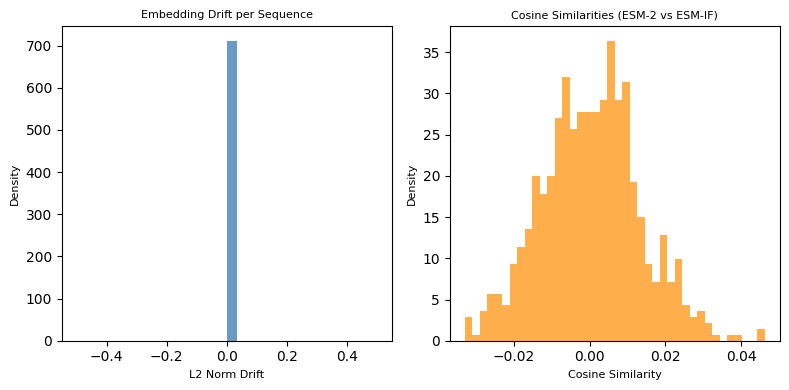

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.33it/s]


Epoch 1: loss=1.6065


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.60it/s]


Average cos-similarity: 0.0044, standard deviation: 0.0119


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.31it/s]


Epoch 2: loss=1.5506


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.51it/s]


Average cos-similarity: 0.0291, standard deviation: 0.0229


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.30it/s]


Epoch 3: loss=1.3985


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.44it/s]


Average cos-similarity: 0.0524, standard deviation: 0.0319


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.24it/s]


Epoch 4: loss=1.2946


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.38it/s]


Average cos-similarity: 0.0705, standard deviation: 0.0354


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.25it/s]


Epoch 5: loss=1.2139


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.46it/s]


Average cos-similarity: 0.0864, standard deviation: 0.035


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.33it/s]


Epoch 6: loss=1.1351


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.49it/s]


Average cos-similarity: 0.1, standard deviation: 0.031


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:11<00:00,  7.93it/s]


Epoch 7: loss=1.0551


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.00it/s]


Average cos-similarity: 0.115, standard deviation: 0.0342


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:02<00:00,  9.02it/s]


Epoch 8: loss=0.9857


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.52it/s]


Average cos-similarity: 0.1208, standard deviation: 0.0386


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.29it/s]


Epoch 9: loss=0.9360


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.53it/s]


Average cos-similarity: 0.1242, standard deviation: 0.038


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:02<00:00,  9.07it/s]


Epoch 10: loss=0.9032


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 11.96it/s]


Average cos-similarity: 0.1279, standard deviation: 0.0369
Saved seq_encoder checkpoint at epoch 10 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_10.pt


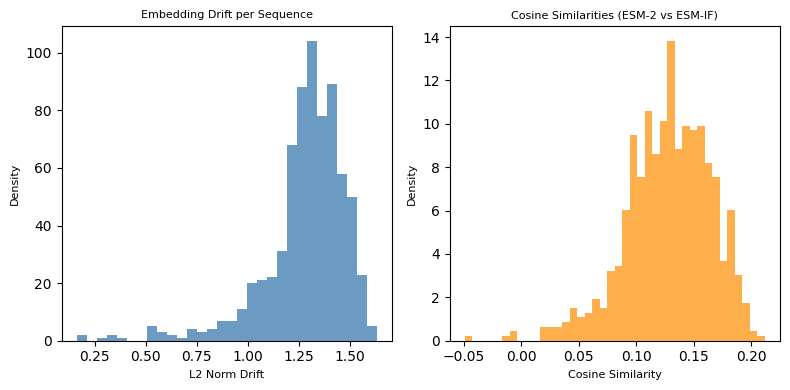

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:08<00:00,  8.33it/s]


Epoch 11: loss=0.8686


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.33it/s]


Average cos-similarity: 0.1301, standard deviation: 0.0364


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.31it/s]


Epoch 12: loss=0.8257


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.62it/s]


Average cos-similarity: 0.1342, standard deviation: 0.0363


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.38it/s]


Epoch 13: loss=0.7846


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.62it/s]


Average cos-similarity: 0.138, standard deviation: 0.0361


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.43it/s]


Epoch 14: loss=0.7653


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.61it/s]


Average cos-similarity: 0.1425, standard deviation: 0.0359


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.37it/s]


Epoch 15: loss=0.7460


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.60it/s]


Average cos-similarity: 0.1454, standard deviation: 0.0361


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.43it/s]


Epoch 16: loss=0.7102


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.63it/s]


Average cos-similarity: 0.1481, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.44it/s]


Epoch 17: loss=0.7066


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.61it/s]


Average cos-similarity: 0.1496, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.40it/s]


Epoch 18: loss=0.6822


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.60it/s]


Average cos-similarity: 0.1507, standard deviation: 0.0361


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.46it/s]


Epoch 19: loss=0.6540


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.59it/s]


Average cos-similarity: 0.1535, standard deviation: 0.0364


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.46it/s]


Epoch 20: loss=0.6336


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.63it/s]


Average cos-similarity: 0.1567, standard deviation: 0.036
Saved seq_encoder checkpoint at epoch 20 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_20.pt


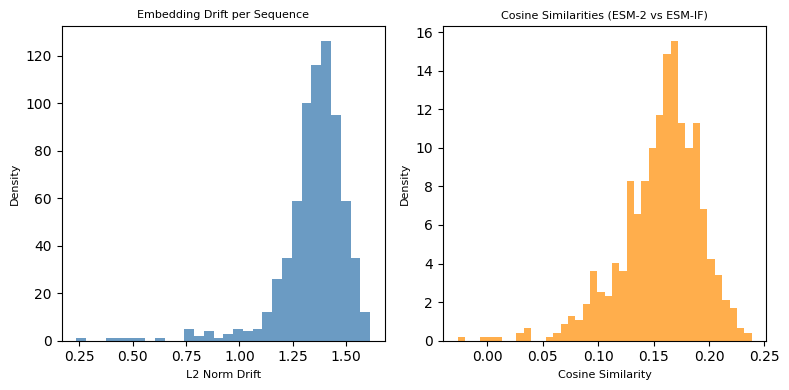

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.40it/s]


Epoch 21: loss=0.6357


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.60it/s]


Average cos-similarity: 0.1573, standard deviation: 0.0365


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [00:59<00:00,  9.51it/s]


Epoch 22: loss=0.6067


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.63it/s]


Average cos-similarity: 0.1586, standard deviation: 0.0371


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [00:59<00:00,  9.52it/s]


Epoch 23: loss=0.6085


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.62it/s]


Average cos-similarity: 0.1588, standard deviation: 0.0368


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.39it/s]


Epoch 24: loss=0.5733


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.63it/s]


Average cos-similarity: 0.1618, standard deviation: 0.0363


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.46it/s]


Epoch 25: loss=0.5735


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.62it/s]


Average cos-similarity: 0.163, standard deviation: 0.0364


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.38it/s]


Epoch 26: loss=0.5472


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.62it/s]


Average cos-similarity: 0.166, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.46it/s]


Epoch 27: loss=0.5403


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.63it/s]


Average cos-similarity: 0.1659, standard deviation: 0.0366


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.45it/s]


Epoch 28: loss=0.5238


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.61it/s]


Average cos-similarity: 0.1673, standard deviation: 0.0366


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.40it/s]


Epoch 29: loss=0.5162


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.58it/s]


Average cos-similarity: 0.1699, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.26it/s]


Epoch 30: loss=0.4880


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.50it/s]


Average cos-similarity: 0.1695, standard deviation: 0.0363
Saved seq_encoder checkpoint at epoch 30 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_30.pt


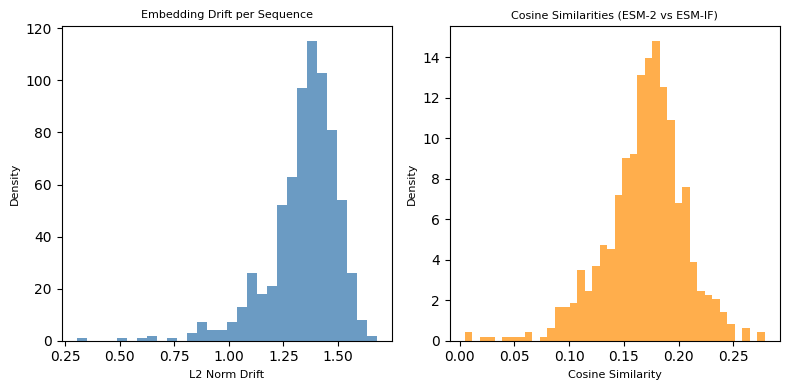

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:15<00:00,  7.54it/s]


Epoch 31: loss=0.4810


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.65it/s]


Average cos-similarity: 0.1707, standard deviation: 0.0361


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.35it/s]


Epoch 32: loss=0.4702


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.54it/s]


Average cos-similarity: 0.1732, standard deviation: 0.0364


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:03<00:00,  8.98it/s]


Epoch 33: loss=0.4627


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.53it/s]


Average cos-similarity: 0.1748, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.22it/s]


Epoch 34: loss=0.4550


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.54it/s]


Average cos-similarity: 0.1761, standard deviation: 0.0367


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:01<00:00,  9.21it/s]


Epoch 35: loss=0.4406


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.25it/s]


Average cos-similarity: 0.1755, standard deviation: 0.0366


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.40it/s]


Epoch 36: loss=0.4447


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.65it/s]


Average cos-similarity: 0.1754, standard deviation: 0.0359


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.41it/s]


Epoch 37: loss=0.4226


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.60it/s]


Average cos-similarity: 0.18, standard deviation: 0.0369


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.42it/s]


Epoch 38: loss=0.4216


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.61it/s]


Average cos-similarity: 0.1794, standard deviation: 0.0361


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.38it/s]


Epoch 39: loss=0.4135


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.57it/s]


Average cos-similarity: 0.1795, standard deviation: 0.0366


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.38it/s]


Epoch 40: loss=0.3993


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.63it/s]


Average cos-similarity: 0.1815, standard deviation: 0.0365
Saved seq_encoder checkpoint at epoch 40 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_40.pt


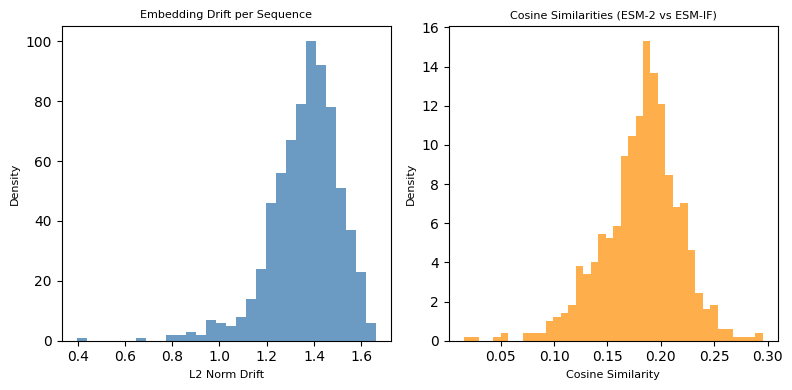

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:00<00:00,  9.40it/s]


Epoch 41: loss=0.4041


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.52it/s]


Average cos-similarity: 0.1854, standard deviation: 0.0366


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:07<00:00,  4.44it/s]


Epoch 42: loss=0.3916


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:15<00:00,  8.94it/s]


Average cos-similarity: 0.1836, standard deviation: 0.0361


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:17<00:00,  4.12it/s]


Epoch 43: loss=0.3767


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:15<00:00,  9.10it/s]


Average cos-similarity: 0.1813, standard deviation: 0.0374


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:15<00:00,  4.21it/s]


Epoch 44: loss=0.3872


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.05it/s]


Average cos-similarity: 0.1834, standard deviation: 0.0366


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.88it/s]


Epoch 45: loss=0.3594


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.03it/s]


Average cos-similarity: 0.1887, standard deviation: 0.0354


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.88it/s]


Epoch 46: loss=0.3547


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.03it/s]


Average cos-similarity: 0.1885, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.88it/s]


Epoch 47: loss=0.3492


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.01it/s]


Average cos-similarity: 0.188, standard deviation: 0.0365


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:25<00:00,  3.91it/s]


Epoch 48: loss=0.3513


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.1881, standard deviation: 0.036


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.87it/s]


Epoch 49: loss=0.3464


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.03it/s]


Average cos-similarity: 0.1862, standard deviation: 0.0369


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.88it/s]


Epoch 50: loss=0.3371


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.03it/s]


Average cos-similarity: 0.1895, standard deviation: 0.0364
Saved seq_encoder checkpoint at epoch 50 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_50.pt


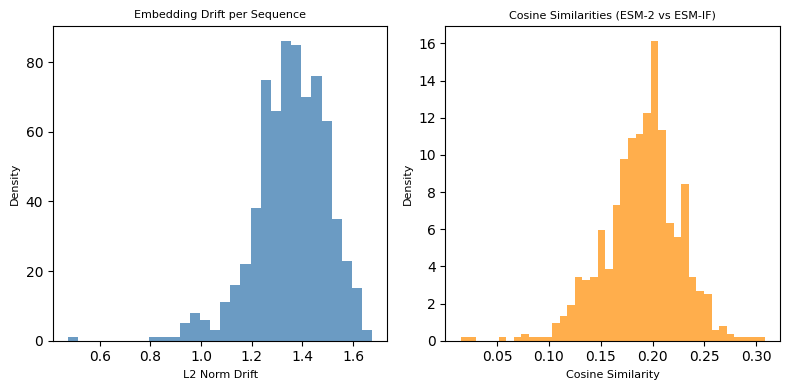

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:27<00:00,  3.84it/s]


Epoch 51: loss=0.3235


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.1908, standard deviation: 0.0355


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.89it/s]


Epoch 52: loss=0.3249


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.06it/s]


Average cos-similarity: 0.1914, standard deviation: 0.0358


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.87it/s]


Epoch 53: loss=0.3194


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.07it/s]


Average cos-similarity: 0.1968, standard deviation: 0.0351


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.88it/s]


Epoch 54: loss=0.3126


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.02it/s]


Average cos-similarity: 0.1918, standard deviation: 0.0361


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:25<00:00,  3.91it/s]


Epoch 55: loss=0.3079


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.06it/s]


Average cos-similarity: 0.1919, standard deviation: 0.0366


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:25<00:00,  3.90it/s]


Epoch 56: loss=0.3002


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.03it/s]


Average cos-similarity: 0.1931, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:25<00:00,  3.90it/s]


Epoch 57: loss=0.3073


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.00it/s]


Average cos-similarity: 0.1949, standard deviation: 0.0361


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.87it/s]


Epoch 58: loss=0.2866


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.05it/s]


Average cos-similarity: 0.1962, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:25<00:00,  6.67it/s]


Epoch 59: loss=0.2866


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:11<00:00, 12.51it/s]


Average cos-similarity: 0.194, standard deviation: 0.0362


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [01:24<00:00,  6.73it/s]


Epoch 60: loss=0.2787


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:26<00:00,  5.30it/s]


Average cos-similarity: 0.1975, standard deviation: 0.0356
Saved seq_encoder checkpoint at epoch 60 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_60.pt


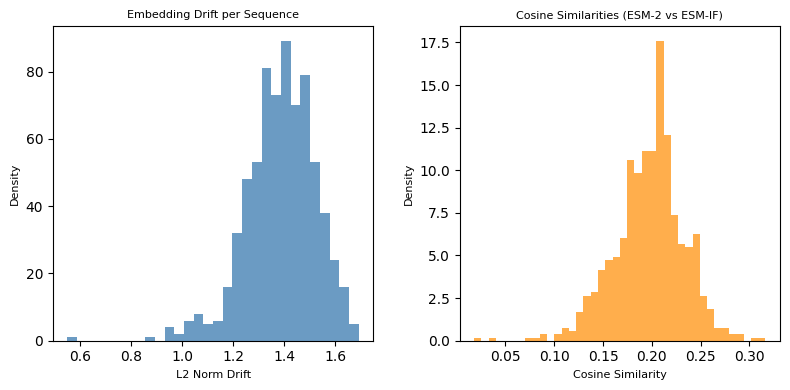

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:07<00:00,  4.44it/s]


Epoch 61: loss=0.2870


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:26<00:00,  5.38it/s]


Average cos-similarity: 0.1966, standard deviation: 0.0357


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:01<00:00,  4.67it/s]


Epoch 62: loss=0.2739


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.02it/s]


Average cos-similarity: 0.1989, standard deviation: 0.0358


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:26<00:00,  3.88it/s]


Epoch 63: loss=0.2586


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.19it/s]


Average cos-similarity: 0.1974, standard deviation: 0.0357


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:10<00:00,  4.34it/s]


Epoch 64: loss=0.2638


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.01it/s]


Average cos-similarity: 0.1978, standard deviation: 0.0369


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.94it/s]


Epoch 65: loss=0.2602


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.2002, standard deviation: 0.0358


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.94it/s]


Epoch 66: loss=0.2581


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.03it/s]


Average cos-similarity: 0.1976, standard deviation: 0.0372


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:25<00:00,  3.91it/s]


Epoch 67: loss=0.2530


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.06it/s]


Average cos-similarity: 0.2019, standard deviation: 0.0354


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.93it/s]


Epoch 68: loss=0.2579


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.1974, standard deviation: 0.0363


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:23<00:00,  3.96it/s]


Epoch 69: loss=0.2343


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.01it/s]


Average cos-similarity: 0.1998, standard deviation: 0.0359


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:23<00:00,  3.96it/s]


Epoch 70: loss=0.2374


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.2025, standard deviation: 0.0347
Saved seq_encoder checkpoint at epoch 70 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_70.pt


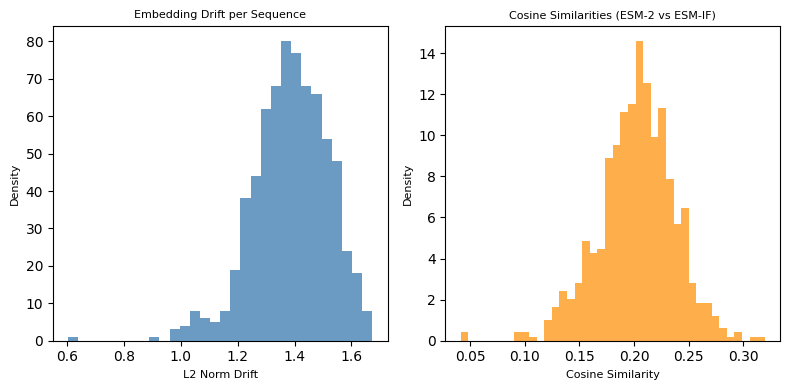

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:23<00:00,  3.95it/s]


Epoch 71: loss=0.2409


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.06it/s]


Average cos-similarity: 0.1975, standard deviation: 0.0366


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.94it/s]


Epoch 72: loss=0.2408


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.05it/s]


Average cos-similarity: 0.1994, standard deviation: 0.0359


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:23<00:00,  3.95it/s]


Epoch 73: loss=0.2382


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.08it/s]


Average cos-similarity: 0.1979, standard deviation: 0.0357


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.92it/s]


Epoch 74: loss=0.2340


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.09it/s]


Average cos-similarity: 0.199, standard deviation: 0.0364


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.92it/s]


Epoch 75: loss=0.2280


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.10it/s]


Average cos-similarity: 0.2001, standard deviation: 0.0365


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.93it/s]


Epoch 76: loss=0.2245


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.12it/s]


Average cos-similarity: 0.1963, standard deviation: 0.0375


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.93it/s]


Epoch 77: loss=0.2123


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.08it/s]


Average cos-similarity: 0.206, standard deviation: 0.0364


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:23<00:00,  3.95it/s]


Epoch 78: loss=0.2136


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.06it/s]


Average cos-similarity: 0.2056, standard deviation: 0.0351


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:25<00:00,  3.91it/s]


Epoch 79: loss=0.2123


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.2031, standard deviation: 0.0355


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.94it/s]


Epoch 80: loss=0.2040


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.2002, standard deviation: 0.0364
Saved seq_encoder checkpoint at epoch 80 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_80.pt


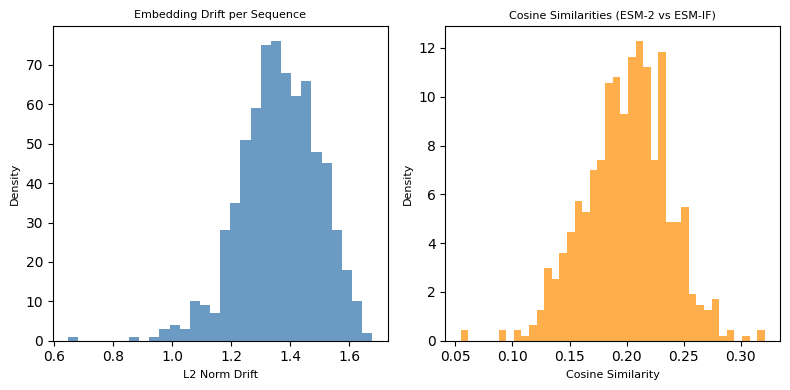

Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.92it/s]


Epoch 81: loss=0.2127


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.2034, standard deviation: 0.0346


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:25<00:00,  3.91it/s]


Epoch 82: loss=0.1985


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.04it/s]


Average cos-similarity: 0.2002, standard deviation: 0.036


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.94it/s]


Epoch 83: loss=0.1919


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  4.99it/s]


Average cos-similarity: 0.2064, standard deviation: 0.0354


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.93it/s]


Epoch 84: loss=0.1919


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.03it/s]


Average cos-similarity: 0.1999, standard deviation: 0.0367


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.93it/s]


Epoch 85: loss=0.1950


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.06it/s]


Average cos-similarity: 0.2029, standard deviation: 0.0355


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.94it/s]


Epoch 86: loss=0.1885


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.08it/s]


Average cos-similarity: 0.2022, standard deviation: 0.0359


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.92it/s]


Epoch 87: loss=0.1878


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:28<00:00,  5.06it/s]


Average cos-similarity: 0.2023, standard deviation: 0.0356


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.92it/s]


Epoch 88: loss=0.1779


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.10it/s]


Average cos-similarity: 0.2063, standard deviation: 0.0351


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:24<00:00,  3.93it/s]


Epoch 89: loss=0.1801


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.08it/s]


Average cos-similarity: 0.2079, standard deviation: 0.0347


Running through epoch: 100%|██████████████████████████████████████████████████████████| 568/568 [02:25<00:00,  3.89it/s]


Epoch 90: loss=0.1868


Computing cosine similarity & embeddings: 100%|███████████████████████████████████████| 142/142 [00:27<00:00,  5.09it/s]


Average cos-similarity: 0.2045, standard deviation: 0.035
Saved seq_encoder checkpoint at epoch 90 -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_90.pt


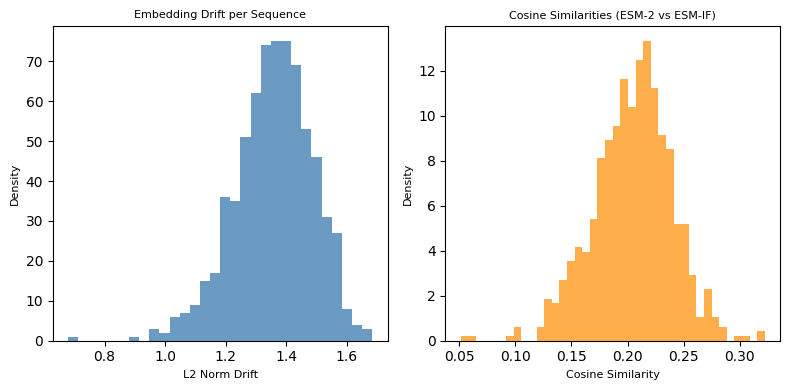

Running through epoch:  20%|███████████▌                                              | 113/568 [00:28<01:54,  3.96it/s]


KeyboardInterrupt: 

In [19]:
# accelerator
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

training_wrapper = TrainWrapper(
    model=model,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
)

start_embeddings, end_embeddings, end_cosine_similarities = training_wrapper.train_model(save_every=10)

### Loading model and tetsing on meta-analysis

In [ ]:
os.listdir("/work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/")

In [ ]:
checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_meta/99af74b6-c57a-4d8d-8487-0f382db02e5d/ESM2boosted_epoch_10.pt"
state_dict = torch.load(checkpoint_path, map_location=device)

model = ESM2EncoderLoRA()
model.load_state_dict(state_dict)
model.to(device)
model.eval()  # or model.train()
# print("Loaded seq_encoder weights from:", checkpoint_path)

### Loading seq_embeds OLD, seqs, struct_embeds

In [ ]:
meta_df_shuffled_LONG_test

In [16]:
class CLIP_PPint_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.seq_len = self.dframe["seq_len"].max()

        # index & storage
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):

            # laod embeddings
            if accession.startswith("t_"):
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"
                esm2_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"
               
                emb_struct = np.load(os.path.join(esmIF_path, f"{accession[2:]}.npy"))
                emb_seq = np.load(os.path.join(esm2_path, f"{accession[2:]}.npy"))
                sequence = str(self.dframe.loc[accession].sequence)

            else:
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
                esm2_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"

                emb_struct = np.load(os.path.join(esmIF_path, f"{accession}.npy"))
                emb_seq = np.load(os.path.join(esm2_path, f"{accession}.npy"))
                sequence = str(self.dframe.loc[accession].sequence)

            # quich check whether embedding dimmension is as it suppose to be
            if emb_seq.shape[1] != self.embedding_dim_seq:
                raise ValueError("Embedding dim mismatch with 'embedding_dim_seq'.")
            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")
                
            # add -5000 to all the padded target rows
            if emb_seq.shape[0] < self.seq_len:
                emb_seq = np.concatenate([emb_seq, np.full((self.seq_len - emb_seq.shape[0], emb_seq.shape[1]), self.emb_pad, dtype=emb_seq.dtype)], axis=0)
            else:
                emb_seq = emb_seq[: self.seq_len] # no padding was usedd

            if emb_struct.shape[0] < self.seq_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.seq_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.seq_len] # no padding was used

            self.samples.append((emb_seq, sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        emb_seq, seq, emb_struct = self.samples[idx]
        emb_seq, emb_struct = torch.from_numpy(emb_seq).float(), torch.from_numpy(emb_struct).float()
        # label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return emb_seq, seq, emb_struct

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        emb_seq_list, seqs_list, emb_struct_list = zip(*out)
    
        # Stack embeddings
        emb_seq_stacked  = torch.stack([torch.as_tensor(x) for x in emb_seq_list],  dim=0)  # [B, ...]        
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        # labels = torch.stack(lbl_list)  # [B]
    
        return emb_seq_stacked, seqs_list, emb_struct_stacked

emb_seq_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
emb_struct_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"

meta_Dataset = CLIP_PPint_w_esmIF(
    meta_df_shuffled_LONG_test,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████| 710/710 [00:02<00:00, 306.28it/s]


In [20]:
    # def compute_embeddings_cos_similariy(self):
    
    #     self.model.eval()
    #     self.model.seq_encoder.eval()
    
    #     all_embeds = []
    #     cosine_similarities = []
    
    #     with torch.no_grad():
    #         for batch in tqdm(self.testing_loader, desc="Computing cosine similarity & embeddings"):
    
    #             seqs, struct_embed, _ = batch
    #             struct_embed = struct_embed.to(self.device)
    
    #             # ---- sequence embeddings ----
    #             seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
    #             seq_mask = create_key_padding_mask(seq_embed)
    #             seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
    
    #             # ---- structure embeddings ----
    #             struct_mask = create_key_padding_mask(struct_embed)
    #             struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]
    #             struct_pooled_proj = self.model.struct_up(struct_pooled)               # [B, 1280]
    
    #             # ---- cosine similarity in CLIP space ----
    #             seq_full = F.normalize(seq_pooled, dim=-1)
    #             struct_full = F.normalize(struct_pooled_proj, dim=-1)
    
    #             cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    
    #             cosine_similarities.extend(cos.cpu().tolist())
    #             all_embeds.extend(seq_full.cpu())
    
    #     all_embeds = torch.stack(all_embeds)
    #     avg_cos = float(np.mean(cosine_similarities))
    #     std_cos = float(np.std(cosine_similarities))
    
    #     return all_embeds, cosine_similarities, avg_cos, std_cos

In [17]:
_loader = DataLoader(meta_Dataset, batch_size=5)
struct_proj = nn.Linear(512, 1280).to(device)
cosine_similarities_BEFORE_per_token = []

for batch in _loader:
    seq_embed, seqs_list, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)
    
    # seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
    seq_mask = create_key_padding_mask(seq_embed)
    seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]

    struct_mask = create_key_padding_mask(struct_embed)
    struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]
    struct_pooled_proj = struct_proj(struct_pooled)               # [B, 1280]

    seq_full = F.normalize(seq_pooled, dim=-1)
    struct_full = F.normalize(struct_pooled_proj, dim=-1)

    cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    cosine_similarities_BEFORE_per_token.append(cos.mean().item())

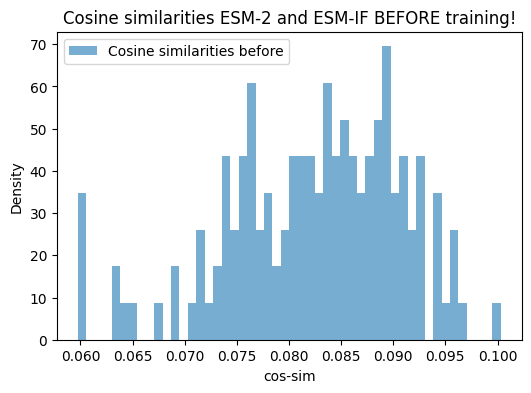

In [18]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_BEFORE_per_token, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF BEFORE training!")
plt.legend()
plt.show()

In [23]:
# cosine_similarities_BEFORE_pooled_per_seq = []

# for batch in _loader:
#     seqs_emeb, seqs_list, structs_emeb = batch
#     seqs_emeb, structs_emeb = seqs_emeb.to(device), structs_emeb.to(device)
    
#     # Project both embeddings if they start at 1280 dim
#     seqs_emeb_proj = proj(seqs_emeb)          # shape: [B, L, 512]

#     # Create masks (must match projected embeddings)
#     seq_mask = create_key_padding_mask(seqs_emeb_proj)
#     struct_mask = create_key_padding_mask(structs_emeb)

#     # Mean-pool (returns shape: [B, 512])
#     vectors_seq = create_mean_of_non_masked(seqs_emeb_proj, seq_mask).cpu().detach().numpy()
#     vectors_struct = create_mean_of_non_masked(structs_emeb, struct_mask).cpu().detach().numpy()

#     # Loop through batch items
#     for i in range(vectors_seq.shape[0]):
#         cosine = np.dot(vectors_seq[i], vectors_struct[i]) / (norm(vectors_seq[i]) * norm(vectors_struct[i]))
#         cosine_similarities_BEFORE_pooled_per_seq.append(cosine)

# plt.figure(figsize=(6, 4))
# plt.hist(cosine_similarities_BEFORE_pooled_per_seq, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# # plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

# plt.xlabel("cos-sim")
# plt.ylabel("Density")
# plt.title("Cosine similarities ESM-2 and ESM-IF BEFORE training!")
# plt.legend()
# plt.show()

In [19]:
_loader = DataLoader(meta_Dataset, batch_size=5)
struct_proj = nn.Linear(512, 1280).to(device)
cosine_similarities_AFTER_per_token = []

for batch in _loader:
    seq_embed, seqs_list, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)
    
    seq_embed = model(seqs_list)  # [B, L, 1280]
    seq_mask = create_key_padding_mask(seq_embed)
    seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]

    struct_mask = create_key_padding_mask(struct_embed)
    struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]
    struct_pooled_proj = struct_proj(struct_pooled)               # [B, 1280]

    seq_full = F.normalize(seq_pooled, dim=-1)
    struct_full = F.normalize(struct_pooled_proj, dim=-1)

    cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    cosine_similarities_AFTER_per_token.append(cos.mean().item())

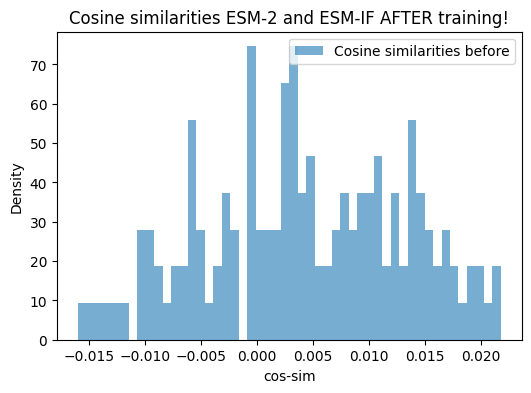

In [20]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_AFTER_per_token, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF AFTER training!")
plt.legend()
plt.show()

In [ ]:
cosine_similarities_AFTER_pooled_per_seq = []

for batch in _loader:
    ___, seqs_list, structs_emeb = batch
    
    # Project both embeddings if they start at 1280 dim
    seqs_emeb = model(seqs_list, meta_df_sample.seq_len_binder.max())
    structs_emeb, seqs_emeb = structs_emeb.to(device), seqs_emeb.to(device)
    seqs_emeb_proj = proj(seqs_emeb)          # shape: [B, L, 512]

    # Create masks (must match projected embeddings)
    seq_mask = create_key_padding_mask(seqs_emeb_proj)
    struct_mask = create_key_padding_mask(structs_emeb)

    # Mean-pool (returns shape: [B, 512])
    vectors_seq = create_mean_of_non_masked(seqs_emeb_proj, seq_mask).cpu().detach().numpy()
    vectors_struct = create_mean_of_non_masked(structs_emeb, struct_mask).cpu().detach().numpy()

    # Loop through batch items
    for i in range(vectors_seq.shape[0]):
        cosine = np.dot(vectors_seq[i], vectors_struct[i]) / (norm(vectors_seq[i]) * norm(vectors_struct[i]))
        cosine_similarities_AFTER_pooled_per_seq.append(cosine)

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_AFTER_pooled_per_seq, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF AFTER training!")
plt.legend()
plt.show()